# DIABETIC RETINOPATHY - Transfer Learning
## Giacomo Deandrea, Giulio Quaglia
## a.a. 2019/2020

La retinopatia diabetica è una malattia degli occhi che può occorrere ai diabetici.
Consiste nel danneggiamento della rete vascolare del tessuto della parte fotosensibile dell'occhio, la retina.

Partendo da un dataset di immagini ridotto, scaricabile al link https://github.com/Nomikxyz/retinopathy-dataset, abbiamo proceduto nel creare un modello che impari a riconoscere gli occhi malati partendo dall'architettura InceptionV3 sviluppata da Google per la competizione ImageNet, mantenedone prima i pesi originari e poi in seguito andando ad allenare gli ultimi layer di quest'ultima alla ricerca di una migliore accuratezza.



# Load Data from disk

*Importo librerie utili*

In [1]:
%pylab inline
import pandas as pd
import tensorflow as tf

Populating the interactive namespace from numpy and matplotlib


*Le immagini sono gia su disco, conto il numero totale di immagini nel dataset*

In [2]:
from os import listdir 

path = "/home/gdeandrea/Scrivania/Diabete/DatiCurati/retinopathy-dataset"
train_dir = path + '/train_set'
validation_dir = path + '/validation_set'

num_sympt_train = len(listdir(train_dir + '/symptoms/'))
num_nosympt_train = len(listdir(train_dir + '/nosymptoms/'))
num_sympt_validation = len(listdir(validation_dir + '/symptoms/'))
num_nosympt_validation = len(listdir(validation_dir + '/nosymptoms/'))

print('N° casi totali: ', num_sympt_train + num_sympt_validation + num_nosympt_train + num_nosympt_validation)
print('N° casi sintomatici: ', num_sympt_train + num_sympt_validation)
print('N° casi asintomatici: ', num_nosympt_train + num_nosympt_validation)
print('----')
print('N° casi training: ', num_nosympt_train + num_sympt_train)
print('N° casi sintomatici training: ', num_sympt_train)
print('N° casi asintomatici training: ', num_nosympt_train)
print('----')
print('N° casi validation: ', num_nosympt_validation + num_sympt_validation)
print('N° casi sintomatici validation: ', num_sympt_validation)
print('N° casi asintomatici validation: ', num_nosympt_validation)

N° casi sintomatici:  2063
N° casi sintomatici:  595
N° casi asintomatici:  1468
----
N° casi training:  1650
N° casi sintomatici training:  476
N° casi asintomatici training:  1174
----
N° casi validation:  413
N° casi sintomatici validation:  119
N° casi asintomatici validation:  294


*Creo generatori che riscalano i miei dati*

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#ImageDataGenerator()
#ImageDataGenerator().flow_from_directory()
train_image_generator = ImageDataGenerator(rescale=1./255)

validation_image_generator = ImageDataGenerator(rescale=1./255)

*Uso methodo che carica le immagini e ci applica le trasformazioni che ho impostato con ImageDataGenerator(), in questo primo frangente solo il riscalamento, e le etichetta a partire dal nome della cartella nella quale si trovano (in questo caso symptoms/nosymptoms)*

In [4]:
batch_size = 16
IMG_HEIGHT = 112
IMG_WIDTH = 112

train_data_gen = train_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary')

val_data_gen = validation_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary')

#nel caso avessi avuto i dati non divisi, avrei potuto evitare la divisione in train e validation con ImageDataGenerator(validation_split = 0.2)

Found 1650 images belonging to 2 classes.
Found 413 images belonging to 2 classes.


*Controllo shape delle immagini e avvenuto riscalamento dei valori di pixel*

In [5]:
sample_train_images, sample_train_labels = next(train_data_gen)

In [6]:
sample_train_images.shape

(16, 112, 112, 3)

In [7]:
amax(sample_train_images)

1.0

In [8]:
amin(sample_train_images)

0.0

# Data Augmentation
*Noto che le foto sono tra loro molto diverse per esposizione, colore, zoom etc. Per prevenire overfitting e "normalizzare" i dati andremo a creare duplicati delle immagini del **train set** applicando trasformazioni di zoom, colore, esposizione etc. Le immagini usate come **validation set** non saranno modificate*

*Mantengo comunque due data set separati in modo da analizzare poi le differenze di performance nei due casi*

*Genero il nuovo trasformatore*

In [9]:
aug_train_image_generator = ImageDataGenerator(
    #brightness_range = (0.5,1.5), #1 è no brightness change
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    rotation_range = 40,
    #featurewise_center=True,
    #featurewise_std_normalization=True,
    zoom_range = 0.2,
    horizontal_flip=True,
    rescale = 1./255)

#aug_train_image_generator.fit(sample_train_images)

*E il nuovo iteratore*

In [10]:
aug_train_data_gen = aug_train_image_generator.flow_from_directory(
    train_dir,
    batch_size=batch_size,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary')

Found 1650 images belonging to 2 classes.


*Controllo shape delle immagini e avvenuto riscalamento dei valori di pixel*

In [11]:
aug_sample_train_images, aug_sample_train_labels = next(aug_train_data_gen)

In [12]:
aug_sample_train_images.shape

(16, 112, 112, 3)

In [13]:
amax(aug_sample_train_images)

1.0

In [14]:
amin(aug_sample_train_images)

0.0

# Inception V3

In [15]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.metrics import categorical_crossentropy

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

from tensorflow.keras.models import Sequential

from tensorflow.keras.callbacks import EarlyStopping


*Modello base: scarico Inception V3 escludendo l'ultimo layer di classificazione, che servirebbe alla classificazione nelle categorie di imagenet, inutili ai nostri scopi*

In [16]:
base_model = InceptionV3(weights = 'imagenet', include_top = False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

Instructions for updating:
Colocations handled automatically by placer.


In [17]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 112, 112, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 55, 55, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 55, 55, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 55, 55, 32)   0           batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
conv2d_1 (

*Setto i layer di InceptionV3 come non allenabili, mantengo i pesi di imagenet*

In [18]:
base_model.trainable = False #Non vado a modificare i pesi già esistenti della mobile net

*Definisco i layer di classificazione utili al caso in analisi*

In [19]:
global_average_layer = GlobalAveragePooling2D() #Flattenizza l'input mediando le matrici due per due per ogni terza componente
#classification_layer1 = Dense(50, activation='relu')
classification_layer = Dense(1, activation='sigmoid')


*Costruisco il modello*

In [20]:
V2model = Sequential()
V2model.add(base_model)
V2model.add(global_average_layer)
V2model.add(classification_layer)

In [21]:
V2model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2, 2, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


*Compilo il modello*

In [22]:
base_learning_rate = 0.0001

V2model.compile(optimizer=Adam(lr=base_learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])


*Definisco quantità utili all'allenamento del modello*

In [25]:
tot_train = num_nosympt_train + num_sympt_train
tot_validation = num_nosympt_validation + num_sympt_validation
steps_per_epoch = tot_train // batch_size
validation_steps = tot_validation // batch_size
epochs = 10
E_S = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

*Alleno la rete sui dati non aumentati*

In [28]:
history = V2model.fit_generator(
    train_data_gen,
    validation_data=val_data_gen,
    validation_steps=validation_steps,
    #callbacks=E_S
    epochs=epochs,
    steps_per_epoch=steps_per_epoch)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
97/97 [==============================] - 247s 3s/step - loss: 0.6443 - acc: 0.6671 - val_loss: 0.7133 - val_acc: 0.6182
Epoch 2/10
97/97 [==============================] - 228s 2s/step - loss: 0.6157 - acc: 0.6923 - val_loss: 0.6536 - val_acc: 0.6860
Epoch 3/10
97/97 [==============================] - 225s 2s/step - loss: 0.5944 - acc: 0.7091 - val_loss: 0.6549 - val_acc: 0.6744
Epoch 4/10
97/97 [==============================] - 229s 2s/step - loss: 0.5726 - acc: 0.7182 - val_loss: 0.6291 - val_acc: 0.6744
Epoch 5/10
97/97 [==============================] - 226s 2s/step - loss: 0.5572 - acc: 0.7201 - val_loss: 0.6228 - val_acc: 0.6802
Epoch 6/10
97/97 [==============================] - 225s 2s/step - loss: 0.5654 - acc: 0.7253 - val_loss: 0.6210 - val_acc: 0.6744
Epoch 7/10
97/97 [==============================] - 225s 2s/step - loss: 0.5420 - acc: 0.7421 - val_loss: 0.6265 - val_acc: 0.6531
Epoch 8/10
97/97 [=================

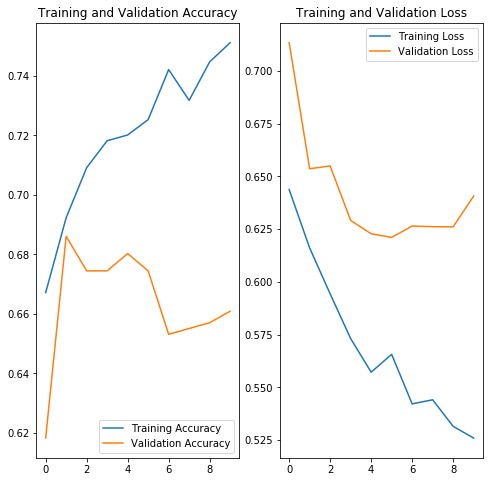

In [29]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

*Chiaro overfitting, procedo allenandola con i dati aumentati (parto dal modello coi pesi allenati prima per convergenza più veloce)*

In [26]:
aug_history = V2model.fit_generator(
    aug_train_data_gen,
    validation_data=val_data_gen,
    validation_steps=validation_steps,
    #callbacks=E_S
    epochs=epochs,
    steps_per_epoch=steps_per_epoch)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
104/104 [==============================] - 227s 2s/step - loss: 0.6441 - acc: 0.6721 - val_loss: 0.6498 - val_acc: 0.6659
Epoch 2/10
104/104 [==============================] - 208s 2s/step - loss: 0.6477 - acc: 0.6873 - val_loss: 0.6575 - val_acc: 0.6901
Epoch 3/10
104/104 [==============================] - 209s 2s/step - loss: 0.6241 - acc: 0.6952 - val_loss: 0.6552 - val_acc: 0.6877
Epoch 4/10
104/104 [==============================] - 209s 2s/step - loss: 0.6052 - acc: 0.7085 - val_loss: 0.6371 - val_acc: 0.6925
Epoch 5/10
104/104 [==============================] - 211s 2s/step - loss: 0.6003 - acc: 0.7067 - val_loss: 0.6280 - val_acc: 0.7046
Epoch 6/10
104/104 [==============================] - 216s 2s/step - loss: 0.5969 - acc: 0.7036 - val_loss: 0.6274 - val_acc: 0.7119
Epoch 7/10
104/104 [==============================] - 209s 2s/step - loss: 0.5916 - acc: 0.7158 - val_loss: 0.6164 - val_acc: 0.7094
Epoch 8/10
104/104 [=

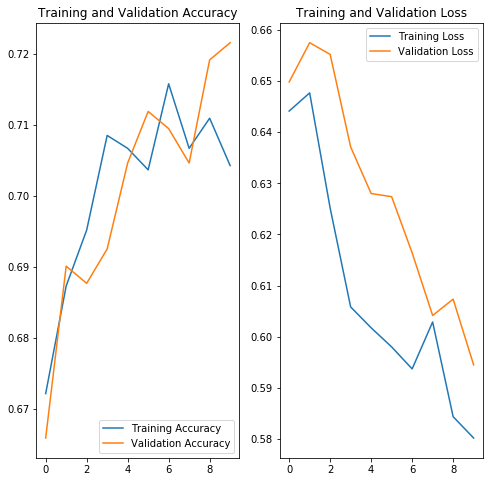

In [27]:
acc = aug_history.history['acc']
val_acc = aug_history.history['val_acc']

loss=aug_history.history['loss']
val_loss=aug_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

*Mi piace quello che vedo, overfitting sembra sistemato. continuo ad allenare per qualche altra epoca perchè vedo che loss sta ancora scendendo*

In [28]:
additional_epochs = 10
again_epochs =  epochs + additional_epochs

In [29]:
again_aug_history = V2model.fit_generator(
    aug_train_data_gen,
    validation_data=val_data_gen,
    validation_steps=validation_steps,
    #callbacks=E_S
    epochs=again_epochs,
    initial_epoch=aug_history.epoch[-1],
    steps_per_epoch=steps_per_epoch)

Epoch 10/20
104/104 [==============================] - 227s 2s/step - loss: 0.5871 - acc: 0.7024 - val_loss: 0.5924 - val_acc: 0.7191
Epoch 11/20
104/104 [==============================] - 207s 2s/step - loss: 0.5903 - acc: 0.7018 - val_loss: 0.5825 - val_acc: 0.7094
Epoch 12/20
104/104 [==============================] - 207s 2s/step - loss: 0.5818 - acc: 0.7079 - val_loss: 0.5899 - val_acc: 0.7167
Epoch 13/20
104/104 [==============================] - 211s 2s/step - loss: 0.5776 - acc: 0.7230 - val_loss: 0.5749 - val_acc: 0.7288
Epoch 14/20
104/104 [==============================] - 208s 2s/step - loss: 0.5782 - acc: 0.7115 - val_loss: 0.5791 - val_acc: 0.7240
Epoch 15/20
104/104 [==============================] - 207s 2s/step - loss: 0.5749 - acc: 0.7073 - val_loss: 0.5710 - val_acc: 0.7094
Epoch 16/20
104/104 [==============================] - 211s 2s/step - loss: 0.5570 - acc: 0.7224 - val_loss: 0.5648 - val_acc: 0.7070
Epoch 17/20
104/104 [==============================] - 208s 2s

In [30]:
acc += again_aug_history.history['acc']
val_acc += again_aug_history.history['val_acc']

loss += again_aug_history.history['loss']
val_loss += again_aug_history.history['val_loss']

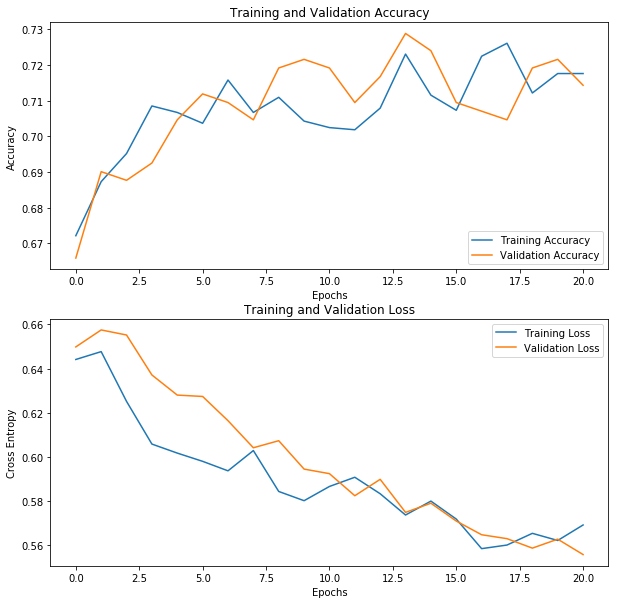

In [31]:
epochs_range = range(again_epochs+1)

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Fine Tuning
*Proviamo a migliorare ulteriormente la performance del modello andando ad allenare i layer più superficiali di inceptionV3*

In [32]:
base_model.trainable = True

*Guardo il numero di layers di inceptionV3*

In [33]:
len(base_model.layers)

311

In [34]:
# Fine-tune from this layer onwards
fine_tune_at = 290

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


*Compilo il modello abbassando il training rate*

In [35]:
V2model.compile(optimizer=Adam(lr=base_learning_rate/10),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

*Guardo il numero di parametri allenabili*

In [36]:
V2model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2, 2, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 2,379,777
Non-trainable params: 19,425,056
_________________________________________________________________


*Alleno il modello comprendendo gli ultimi layer di inceptionV3 e plotto i risultati*

In [37]:
total_epochs =  again_epochs + additional_epochs

In [38]:
fine_aug_history = V2model.fit_generator(
    aug_train_data_gen,
    validation_data=val_data_gen,
    validation_steps=validation_steps,
    #callbacks=E_S
    epochs=total_epochs,
    initial_epoch=again_aug_history.epoch[-1],
    steps_per_epoch=steps_per_epoch)

Epoch 20/30
104/104 [==============================] - 231s 2s/step - loss: 0.5552 - acc: 0.7285 - val_loss: 0.5458 - val_acc: 0.7215
Epoch 21/30
104/104 [==============================] - 210s 2s/step - loss: 0.5564 - acc: 0.7218 - val_loss: 0.5347 - val_acc: 0.7312
Epoch 22/30
104/104 [==============================] - 210s 2s/step - loss: 0.5573 - acc: 0.7206 - val_loss: 0.5264 - val_acc: 0.7312
Epoch 23/30
104/104 [==============================] - 210s 2s/step - loss: 0.5538 - acc: 0.7291 - val_loss: 0.5257 - val_acc: 0.7409
Epoch 24/30
104/104 [==============================] - 210s 2s/step - loss: 0.5455 - acc: 0.7303 - val_loss: 0.5208 - val_acc: 0.7433
Epoch 25/30
104/104 [==============================] - 212s 2s/step - loss: 0.5432 - acc: 0.7248 - val_loss: 0.5098 - val_acc: 0.7337
Epoch 26/30
104/104 [==============================] - 210s 2s/step - loss: 0.5416 - acc: 0.7339 - val_loss: 0.5094 - val_acc: 0.7361
Epoch 27/30
104/104 [==============================] - 207s 2s

In [39]:
acc += fine_aug_history.history['acc']
val_acc += fine_aug_history.history['val_acc']

loss += fine_aug_history.history['loss']
val_loss += fine_aug_history.history['val_loss']

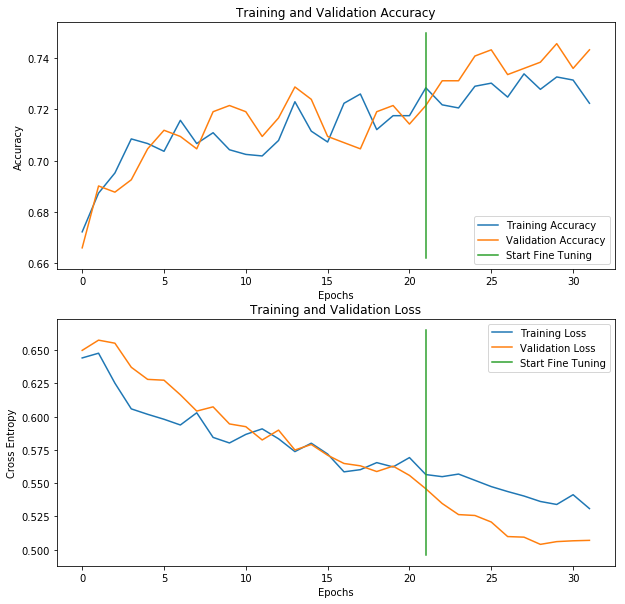

In [40]:
epochs_range = range(total_epochs+2)

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot([again_epochs+1,again_epochs+1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.plot([again_epochs+1,again_epochs+1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

*Sembra effettivamente che il fine tuning abbia portato a benefici in termini di accuracy sia sul train che sul validation set e si nota la diminuzione della funzione d'errore su entrambe i set di dati.
Non è possibile però stabilirlo con certezza. Infatti avremmo dovuto allenare per più epoche nelle fasi precedenti in modo da essere sicuri di essere arrivati a una convergenza dei dati*

*Per migliorare la resa si potrebbe per prima cosa utilizzare il data set completo messo a disposizione degli utenti su Kaggle. Potremmo così non solo valutare binariamente se un occhio è sano o malato, ma cercarne di predire la gravità (rappresentata in 4 categorie nel dataset principale). Date queste modifiche potremmo anche migliorare la rappresentazione dei dati, usando per esempio un dataset di allenamento uniforme (con lo stesso numero di immagini per categoria) o modificandone la standardizzazione.*